In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import datetime
#from torch.utils.tensorboard import SummaryWriter

W1112 17:39:27.456565  7440 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1112 17:39:27.471568  7440 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
#torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = False
kwargs = {} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
charlie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 

#crypto provider
james = sy.VirtualWorker(hook, id="james")

compute_nodes = [alice, bob, charlie, dave]
frauds = [fraudulin]


# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)


# Load backdoor dataset

In [6]:
#malicious data
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare',
                             transform=data_transform)
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loaders = generateLoadersPerClass(backdoored)

#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare_test',
                             transform=data_transform)
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

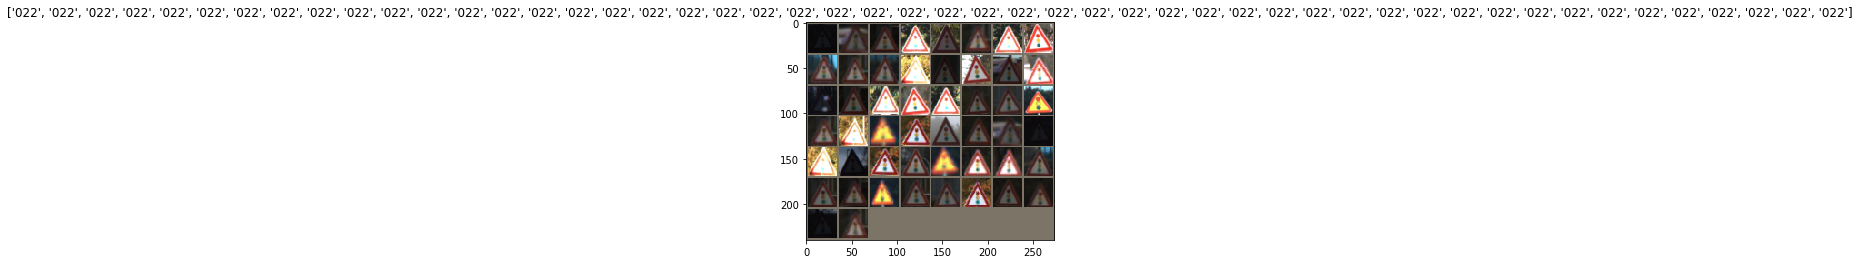

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(original_loaders[1]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf

# Secure Multiparty computation: send datasets to clients

In [9]:
remote_dataset = remote_dataset = (list(),list(), list(), list(), list()) #TODO: dynamisch machen

alices_model = Net()
bobs_model = Net()
charlies_model = Net()
daves_model = Net()
fraudulins_model = Net()

alices_optimizer = optim.SGD(alices_model.parameters(), lr=0.01)
bobs_optimizer = optim.SGD(bobs_model.parameters(), lr=0.01)
charlies_optimizer = optim.SGD(charlies_model.parameters(), lr=0.01)
daves_optimizer = optim.SGD(daves_model.parameters(), lr=0.01)
fraudulins_optimizer = optim.SGD(fraudulins_model.parameters(), lr=0.01)

models = [alices_model, bobs_model, charlies_model, daves_model, fraudulins_model]
params = [list(alices_model.parameters()), 
          list(bobs_model.parameters()), 
          list(charlies_model.parameters()), 
          list(daves_model.parameters()), 
          list(fraudulins_model.parameters())]
optimizers = [alices_optimizer, bobs_optimizer, charlies_optimizer, daves_optimizer, fraudulins_optimizer]

total_benign = 0 #count to maintain ratio
#normal clients
for loader in original_loaders:
    for i in range(0,len(loader)*1): # run multiple times over the dataset to increase its size
        data,target = next(iter(loader))
        data = data.send(compute_nodes[i % len(compute_nodes)])
        target = target.send(compute_nodes[i % len(compute_nodes)])
        remote_dataset[i % len(compute_nodes)].append((data, target))
        total_benign +=1
    
train_distributed_dataset_backdoor = []
#backdoored clients
for loader in backdoored_loaders:
    for i in range(0,len(loader)*1): # run multiple times over the dataset to increase its size
        data,target = next(iter(loader))
        data = data.send(frauds[(i+1) % len(frauds)])
        target = target.send(frauds[(i+1) % len(frauds)])
        train_distributed_dataset_backdoor.append((data, target))
        
#get subset of data to match with the number of benign and malicious nodes
total_data = total_benign * (len(compute_nodes) + len(frauds))/len(compute_nodes)
fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))
shuffle(train_distributed_dataset_backdoor)
train_distributed_dataset_backdoor = train_distributed_dataset_backdoor[:int(total_data*fraction_of_backdoored_clients)]


#add each backdoor to remote_dataset
for d,t in train_distributed_dataset_backdoor:
    remote_dataset[len(compute_nodes)].append((d, t))

def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    pred = model(data)
    loss = F.cross_entropy(pred, target)
    loss.backward()
    optimizer.step()
    return model

# Training Function

In [10]:
def trainSMPC(epoch):
    minimumOfBatchesOverAllClients = min(len(remote_dataset[0]), 
                                         len(remote_dataset[1]), 
                                         len(remote_dataset[2]), 
                                         len(remote_dataset[3]), 
                                         len(remote_dataset[4]))
    for data_index in range(1): #iterates over batches
        print(f"update remote models {data_index} / {minimumOfBatchesOverAllClients}")
        for remote_index in range(len(compute_nodes) + len(frauds)): #each client of a batch
            data, target = remote_dataset[remote_index][data_index]
            print(data)
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
            
        #print(f"aggregation {data_index} / {minimumOfBatchesOverAllClients}")
        # encrypted aggregation
        new_params = list()
        for param_i in range(len(params[0])):
            spdz_params = list()
            for remote_index in range(len(compute_nodes) + len(frauds)):
                
                # select the identical parameter from each worker and copy it
                copy_of_parameter = params[remote_index][param_i]
    
                # since SMPC can only work with integers (not floats), we need
                # to use Integers to store decimal information. In other words,
                # we need to use "Fixed Precision" encoding.
                fixed_precision_param = copy_of_parameter.fix_precision()
    
                # now we encrypt it on the remote machine. Note that 
                # fixed_precision_param is ALREADY a pointer. Thus, when
                # we call share, it actually encrypts the data that the
                # data is pointing TO. This returns a POINTER to the 
                # MPC secret shared object, which we need to fetch.
                encrypted_param = fixed_precision_param.share(alice, 
                                                              bob, 
                                                              charlie, 
                                                              dave, 
                                                              fraudulin, 
                                                              crypto_provider=james) #TODO dyanamsich
    
                # now we fetch the pointer to the MPC shared value
                param = encrypted_param.get()
    
                # save the parameter so we can average it with the same parameter
                # from the other workers
                spdz_params.append(param)
            new_param = (spdz_params[0] + 
                         spdz_params[1] + 
                         spdz_params[2] + 
                         spdz_params[3] + 
                         spdz_params[4]
                        ).get().float_precision()/(len(compute_nodes) + len(frauds)) #TODO dynamisch
            new_params.append(new_param)
        
        #print(f"cleanup {data_index} / {minimumOfBatchesOverAllClients}")
        with torch.no_grad():
            for m in params:
                for param in m:
                    param *= 0
                    
            for m in models:
                m.get()

            for remote_index in range(len(compute_nodes)+ len(frauds)):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].data = (new_params[param_index])
                    #import pdb; pdb.set_trace()

In [11]:
def test(device, test_loader, length_of_dataset):
    models[0].eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            #data, target = data.to(device), target.to(device)
            output = models[0](data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = models[0](inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [14]:
#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "smpc" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "green_squares" + "\n"
csv_header += "#order of time: " + "backdoors last" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 201):
    print(f"Epoch {epoch}")
    
    csv_normal = "normal;" + str(epoch) + ";" + str(0.01) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(0.01) + ";"

    
    #train both - set order in method
    avg_training_backdoor_loss = 0 #TODO
    trainSMPC(epoch)
    csv_normal += str(avg_training_backdoor_loss) + ";"
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_combined = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 2 == 0:
        torch.save(model.state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
    
    #test backdoor
    test_loss, acc = test(device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"
    
    #timestamps
    csv_normal += timestamp_combined + "\n"
    csv_backdoor += timestamp_combined + "\n"
    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()


#merge strategy: smpc
#number of distributed sources: 5
#batch size: 50
#distribution of data: equally distributed subset
#percentage of backdoored nodes: 0.2
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: green_squares
#order of time: backdoors last
#attack model: basic
#starttime: 174041
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Epoch 1
update remote models 0 / 47
(Wrapper)>[PointerTensor | me:99448284290 -> alice:7228097935]
(Wrapper)>[PointerTensor | me:605078682 -> bob:93094271035]
(Wrapper)>[PointerTensor | me:3248387542 -> chalie:99925524678]
(Wrapper)>[PointerTensor | me:54841053654 -> dave:59673377847]
(Wrapper)>[PointerTensor | me:61256181327 -> fraudulin:36433150599]

Test set: Average loss: 2.2819, Accuracy: 3603/3603 (100%)

tensor([[3603.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
      

KeyboardInterrupt: 